# Stock Predictor

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import optuna
import plotly

def load_stock_data(ticker: str, start: str = "2025-01-01", end: str = None):
    """
    Loads daily OHLCV data for a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): Stock ticker symbol (e.g., 'AAPL')
        start (str): Start date for data (default: '2015-01-01')
        end (str): End date for data (default: today)

    Returns:
        pd.DataFrame: DataFrame containing stock data
    """
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    data = data.rename(columns=str.lower)
    return data

In [ ]:
def create_features(data: pd.DataFrame, lag: int = 30):
    """
    Converts OHLCV data into supervised learning features for next-day prediction.

    Args:
        data (pd.DataFrame): Daily stock data with columns ['open','high','low','close','volume']
        lag (int): Number of past days used as features

    Returns:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target values (next-day close)
    """
    df = data.copy()

    # Try if these improve prediction:
    df["return"] = df["close"].pct_change()
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_20"] = df["close"].rolling(20).mean()
    df["momentum"] = df["close"] / df["close"].shift(5) - 1
    df["volatility"] = df["return"].rolling(10).std()

    df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=14).rsi()
    macd = ta.trend.MACD(df["close"])
    df["macd"] = macd.macd()
    bb = ta.volatility.BollingerBands(df["close"])
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()

    df = df.dropna()

    features = []
    targets = []
    target_dates = []
    feature_dates = []

    for i in range(lag, len(df)):
        window = df.iloc[i - lag:i]
        next_close = df.iloc[i]["close"]
        next_date = df.index[i]
        window_dates = df.index[i - lag:i]

        # flatten window data (close & volume)
        feat = np.concatenate([
            window["close"].values.flatten(),
            window["volume"].values.flatten()
        ])
        features.append(feat)
        targets.append(next_close)
        target_dates.append(next_date)
        feature_dates.append(window_dates)

    X = np.array(features)
    y = np.array(targets).flatten()
    target_dates = np.array(target_dates)
    return X, y, target_dates, feature_dates



In [24]:
def walk_forward_sliding_window(X, y, target_dates, train_window=200, step=1, params=None):
    """
    Walk-forward validation with a sliding training window for next-day stock prediction.

    Args:
        X (np.ndarray): Feature matrix
        y (np.ndarray): Target vector
        target_dates (np.ndarray): Corresponding dates
        train_window (int): Number of past samples used for training at each step
        step (int): How many steps to move the window forward each iteration
        params (dict): Hyperparameters for XGBRegressor

    Returns:
        results (pd.DataFrame): DataFrame with date, actual, predicted
        metrics (dict): Overall MAE and RMSE
    """
    if params is None:
        params = {
            "n_estimators": 600,
            "learning_rate": 0.03,
            "max_depth": 5,
            "min_child_weight": 5,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0.2,
            "reg_lambda": 2.0,
            "reg_alpha": 0.5,
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "random_state": 42,
        }

    n_samples = len(X)
    predictions = []
    actuals = []
    dates = []

    start_idx = train_window
    for i in range(start_idx, n_samples, step):
        train_idx = slice(i - train_window, i)
        test_idx = i

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx:test_idx+1], y[test_idx:test_idx+1]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        predictions.append(y_pred[0])
        actuals.append(y_test[0])
        dates.append(target_dates[test_idx])

    results = pd.DataFrame({
        "date": dates,
        "actual": actuals,
        "predicted": predictions
    }).set_index("date")

    mae = mean_absolute_error(results["actual"], results["predicted"])
    rmse = root_mean_squared_error(results["actual"], results["predicted"])
    mape = np.mean(np.abs((results["actual"] - results["predicted"]) / results["actual"])) * 100

    # Directional Accuracy (DA)
    actual_change = np.sign(results["actual"].diff())
    predicted_change = np.sign(results["predicted"].diff())
    da = np.mean(actual_change[1:] == predicted_change[1:]) * 100

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "Directional_Accuracy": da
    }

    print(f"\nWalk-forward (sliding window) metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"DA:   {da:.2f}%")

    return results, metrics

In [25]:
def optimize_window_sizes(data, lag_values, train_window_values, ticker="MSFT"):
    """
    Simple grid search over lag and train_window sizes using walk-forward validation.

    Args:
        data (pd.DataFrame): Stock data (OHLCV)
        lag_values (list): Candidate lag values (e.g. [5, 10, 20, 30])
        train_window_values (list): Candidate train_window sizes (e.g. [50, 100, 200])
        ticker (str): Ticker symbol for reporting

    Returns:
        pd.DataFrame: Results sorted by MAE
    """
    results_summary = []

    for lag in lag_values:
        X, y, target_dates, _ = create_features(data, lag)
        for tw in train_window_values:
            if tw >= len(X) // 2:
                continue
            print(f"\nTesting lag={lag}, train_window={tw}...")
            try:
                _, metrics = walk_forward_sliding_window(X, y, target_dates, train_window=tw)
                results_summary.append({
                    "lag": lag,
                    "train_window": tw,
                    **metrics
                })
            except Exception as e:
                print(f"  ❌ Failed for lag={lag}, train_window={tw}: {e}")

    df_results = pd.DataFrame(results_summary)
    df_results = df_results.sort_values("MAE")
    print("\n=== Optimization Results (sorted by MAE) ===")
    print(df_results.head(20))
    return df_results

In [26]:
def plot_walk_forward_results(results: pd.DataFrame, ticker: str = "MSFT"):
    """
    Plots walk-forward prediction results:
    - Actual vs predicted prices
    - Prediction error over time

    Args:
        results (pd.DataFrame): DataFrame with 'actual' and 'predicted' columns indexed by date
        ticker (str): Stock ticker for title
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]})

    ax[0].plot(results.index, results["actual"], label="Actual", color="black")
    ax[0].plot(results.index, results["predicted"], label="Predicted", color="red", alpha=0.7)
    ax[0].set_ylabel("Close Price")
    ax[0].set_title(f"{ticker} — Next-Day Close Prediction (Walk-Forward, Sliding Window)")
    ax[0].legend(loc="upper left")
    ax[0].grid(True, linestyle="--", alpha=0.4)

    errors = results["predicted"] - results["actual"]
    ax[1].plot(results.index, errors, color="blue", alpha=0.6)
    ax[1].axhline(0, color="black", linewidth=1)
    ax[1].set_ylabel("Prediction Error")
    ax[1].set_xlabel("Date")
    ax[1].grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

In [27]:
def plot_sample(X: np.ndarray, y: np.ndarray, target_dates: np.ndarray, feature_dates: list, 
                sample_idx: int = 0, lag: int = 30, ticker: str = "MSFT"):
    """
    Plots the feature vector (closing prices and volumes) for a given sample,
    and shows the next-day target price.

    Args:
        X (np.ndarray): Feature matrix (n_samples, lookback*2)
        y (np.ndarray): Target array (n_samples,)
        sample_idx (int): Index of the sample to visualize
        lookback (int): Number of past days used in features
        ticker (str): Stock ticker for title
    """
    first_features = X[sample_idx]
    first_target = y[sample_idx]
    target_date = target_dates[sample_idx]
    window_dates = feature_dates[sample_idx]

    closes = first_features[:lag]
    volumes = first_features[lag:]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(window_dates, closes, marker='o', color=color, label='Past closes')
    ax1.scatter(target_date, first_target, color='red', label='Next day target')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Volume', color=color)
    ax2.bar(window_dates, volumes, alpha=0.3, color=color, label='Past volumes')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'{ticker} - Sample {sample_idx} features (closes + volumes) vs. next-day target')
    plt.show()

    

In [28]:
ticker = "MSFT"
data = load_stock_data(ticker, start="2023-01-01")

lag_values = [2, 3, 4, 5, 6, 7, 10, 15, 20]
train_window_values = [40, 50, 60, 80, 100, 120, 150]

results_df = optimize_window_sizes(data, lag_values, train_window_values, ticker)

best = results_df.iloc[0]
print(f"\nBest configuration: lag={best.lag}, train_window={best.train_window}")

Fetching data for MSFT...

Testing lag=2, train_window=40...

Walk-forward (sliding window) metrics:
MAE:  6.0025
RMSE: 7.8741
MAPE: 1.54%
DA:   50.84%

Testing lag=2, train_window=50...

Walk-forward (sliding window) metrics:
MAE:  5.9723
RMSE: 7.9385
MAPE: 1.52%
DA:   51.63%

Testing lag=2, train_window=60...

Walk-forward (sliding window) metrics:
MAE:  5.9111
RMSE: 7.7915
MAPE: 1.50%
DA:   50.08%

Testing lag=2, train_window=80...

Walk-forward (sliding window) metrics:
MAE:  5.6231
RMSE: 7.4023
MAPE: 1.40%
DA:   49.27%

Testing lag=2, train_window=100...

Walk-forward (sliding window) metrics:
MAE:  5.4985
RMSE: 7.2859
MAPE: 1.36%
DA:   48.74%

Testing lag=2, train_window=120...

Walk-forward (sliding window) metrics:
MAE:  5.4371
RMSE: 7.1883
MAPE: 1.33%
DA:   48.00%

Testing lag=2, train_window=150...

Walk-forward (sliding window) metrics:
MAE:  5.4743
RMSE: 7.1727
MAPE: 1.32%
DA:   48.44%

Testing lag=3, train_window=40...

Walk-forward (sliding window) metrics:
MAE:  5.9485
R

In [30]:
def optuna_xgb(data, lag, train_window, n_trials=50, alpha=0.2):
    X, y, dates, _ = create_features(data, lag)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_categorical("n_estimators", [200, 400, 600]),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "random_state": 42,
            "objective": "reg:squarederror",
            "eval_metric": "mae",
        }
        _, metrics = walk_forward_sliding_window(X, y, dates, train_window=train_window, params=params, step=1)
        
        if metrics is None:
            return float("inf")
        
        mae = metrics["MAE"]
        da = metrics["Directional_Accuracy"]
        trial.set_user_attr("MAE", mae)
        trial.set_user_attr("DA", da)

        # Composite objective: minimize MAE, maximize DA
        objective_value = mae - alpha * (da / 100)
        return objective_value

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    return study

In [31]:
lag = 3
train_window = 150

study = optuna_xgb(data, lag=lag, train_window=train_window, n_trials=50)

#optuna.visualization.plot_optimization_history(study).show()
#optuna.visualization.plot_param_importances(study).show()

print("\n=== Optuna optimization finished ===")
print("Best objective value:", study.best_value)
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

trials_df = study.trials_dataframe(attrs=("number", "value", "state", "user_attrs"))
print(trials_df.head())

[I 2025-10-15 22:39:03,685] A new study created in memory with name: no-name-59d40f79-115f-419d-a7ae-e5df959ab220
[I 2025-10-15 22:41:02,474] Trial 0 finished with value: 6.165240827664387 and parameters: {'n_estimators': 400, 'learning_rate': 0.022072076541772092, 'max_depth': 5, 'subsample': 0.5363637010732047, 'colsample_bytree': 0.89054707160093, 'reg_alpha': 4.636895629122972, 'reg_lambda': 4.806003874830516}. Best is trial 0 with value: 6.165240827664387.



Walk-forward (sliding window) metrics:
MAE:  6.2634
RMSE: 8.1562
MAPE: 1.51%
DA:   49.08%


[I 2025-10-15 22:42:32,814] Trial 1 finished with value: 5.627198932316261 and parameters: {'n_estimators': 200, 'learning_rate': 0.07515957615820643, 'max_depth': 6, 'subsample': 0.5699598841940547, 'colsample_bytree': 0.9323532946563131, 'reg_alpha': 3.6177413323950374, 'reg_lambda': 3.574056856868517}. Best is trial 1 with value: 5.627198932316261.



Walk-forward (sliding window) metrics:
MAE:  5.7228
RMSE: 7.5062
MAPE: 1.38%
DA:   47.79%


[I 2025-10-15 22:43:57,488] Trial 2 finished with value: 6.679292395355505 and parameters: {'n_estimators': 200, 'learning_rate': 0.027406489826414537, 'max_depth': 7, 'subsample': 0.7309975179648818, 'colsample_bytree': 0.5191301311664697, 'reg_alpha': 2.166819067691405, 'reg_lambda': 4.77115942716121}. Best is trial 1 with value: 5.627198932316261.



Walk-forward (sliding window) metrics:
MAE:  6.7730
RMSE: 8.7865
MAPE: 1.63%
DA:   46.88%


[I 2025-10-15 22:47:16,284] Trial 3 finished with value: 5.591673342215326 and parameters: {'n_estimators': 600, 'learning_rate': 0.0890142446716618, 'max_depth': 6, 'subsample': 0.564720297013763, 'colsample_bytree': 0.6456842969774461, 'reg_alpha': 1.8121737837519314, 'reg_lambda': 3.438986523049717}. Best is trial 3 with value: 5.591673342215326.



Walk-forward (sliding window) metrics:
MAE:  5.6895
RMSE: 7.4603
MAPE: 1.38%
DA:   48.90%


[I 2025-10-15 22:51:36,603] Trial 4 finished with value: 5.400699331795146 and parameters: {'n_estimators': 600, 'learning_rate': 0.0261540678633407, 'max_depth': 7, 'subsample': 0.5235902657626246, 'colsample_bytree': 0.7246070211122746, 'reg_alpha': 2.681546994457812, 'reg_lambda': 1.264273747470868}. Best is trial 4 with value: 5.400699331795146.



Walk-forward (sliding window) metrics:
MAE:  5.4956
RMSE: 7.2295
MAPE: 1.33%
DA:   47.43%


[I 2025-10-15 22:52:20,546] Trial 5 finished with value: 5.621146033380202 and parameters: {'n_estimators': 200, 'learning_rate': 0.037171917590305, 'max_depth': 3, 'subsample': 0.9389816218243261, 'colsample_bytree': 0.7822263208156955, 'reg_alpha': 4.564800197276057, 'reg_lambda': 2.1021470300066585}. Best is trial 4 with value: 5.400699331795146.



Walk-forward (sliding window) metrics:
MAE:  5.7156
RMSE: 7.4807
MAPE: 1.38%
DA:   47.24%


[I 2025-10-15 22:53:50,090] Trial 6 finished with value: 5.58438851469218 and parameters: {'n_estimators': 200, 'learning_rate': 0.08063943089143316, 'max_depth': 7, 'subsample': 0.7305834142888956, 'colsample_bytree': 0.5612668749679817, 'reg_alpha': 1.9252436966713655, 'reg_lambda': 3.2487451000836636}. Best is trial 4 with value: 5.400699331795146.



Walk-forward (sliding window) metrics:
MAE:  5.6785
RMSE: 7.4726
MAPE: 1.38%
DA:   47.06%


[I 2025-10-15 22:57:44,361] Trial 7 finished with value: 5.601897010864982 and parameters: {'n_estimators': 600, 'learning_rate': 0.04168692704913003, 'max_depth': 8, 'subsample': 0.9295768020586545, 'colsample_bytree': 0.5038143363792525, 'reg_alpha': 1.5131178224766377, 'reg_lambda': 0.41910593677084607}. Best is trial 4 with value: 5.400699331795146.



Walk-forward (sliding window) metrics:
MAE:  5.6934
RMSE: 7.4737
MAPE: 1.38%
DA:   45.77%


[I 2025-10-15 22:59:14,805] Trial 8 finished with value: 7.585040731167575 and parameters: {'n_estimators': 200, 'learning_rate': 0.019011816317077688, 'max_depth': 7, 'subsample': 0.9538232755497861, 'colsample_bytree': 0.6265867928912989, 'reg_alpha': 0.7886237337113866, 'reg_lambda': 4.819461064996912}. Best is trial 4 with value: 5.400699331795146.



Walk-forward (sliding window) metrics:
MAE:  7.6788
RMSE: 9.9281
MAPE: 1.83%
DA:   46.88%


[I 2025-10-15 23:00:15,160] Trial 9 finished with value: 5.595443368202535 and parameters: {'n_estimators': 200, 'learning_rate': 0.041771937730962494, 'max_depth': 4, 'subsample': 0.6459730422474701, 'colsample_bytree': 0.7904850384077529, 'reg_alpha': 3.1741938066831024, 'reg_lambda': 1.7554746944802209}. Best is trial 4 with value: 5.400699331795146.



Walk-forward (sliding window) metrics:
MAE:  5.6914
RMSE: 7.4422
MAPE: 1.38%
DA:   47.98%


[I 2025-10-15 23:06:59,678] Trial 10 finished with value: 5.10294604479012 and parameters: {'n_estimators': 600, 'learning_rate': 0.01007137568515893, 'max_depth': 8, 'subsample': 0.8087973899920774, 'colsample_bytree': 0.6844839099187828, 'reg_alpha': 0.004452556922518003, 'reg_lambda': 0.1741395818808562}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.1927
RMSE: 6.8935
MAPE: 1.26%
DA:   44.85%


[I 2025-10-15 23:13:42,948] Trial 11 finished with value: 5.131812225028881 and parameters: {'n_estimators': 600, 'learning_rate': 0.010985252170618498, 'max_depth': 8, 'subsample': 0.8088324183833363, 'colsample_bytree': 0.6950529141360641, 'reg_alpha': 0.10256164203743169, 'reg_lambda': 0.23726881654222465}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.2230
RMSE: 6.9333
MAPE: 1.27%
DA:   45.59%


[I 2025-10-15 23:20:00,789] Trial 12 finished with value: 5.1669280627065906 and parameters: {'n_estimators': 600, 'learning_rate': 0.01006542156617763, 'max_depth': 8, 'subsample': 0.8238480100463594, 'colsample_bytree': 0.6908478576873934, 'reg_alpha': 0.4307837583422512, 'reg_lambda': 0.08194550185754396}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.2574
RMSE: 6.9519
MAPE: 1.28%
DA:   45.22%


[I 2025-10-15 23:27:08,287] Trial 13 finished with value: 5.191316258553486 and parameters: {'n_estimators': 600, 'learning_rate': 0.011079102469673568, 'max_depth': 8, 'subsample': 0.8351848950054054, 'colsample_bytree': 0.8399877482286436, 'reg_alpha': 0.039868112072217354, 'reg_lambda': 0.7031829666188313}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.2829
RMSE: 6.9683
MAPE: 1.28%
DA:   45.77%


[I 2025-10-15 23:30:43,540] Trial 14 finished with value: 5.892274579677592 and parameters: {'n_estimators': 400, 'learning_rate': 0.014747536155816789, 'max_depth': 8, 'subsample': 0.8240290368210539, 'colsample_bytree': 0.6255725322933517, 'reg_alpha': 1.0679724536398287, 'reg_lambda': 1.2109892280858474}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.9820
RMSE: 7.8183
MAPE: 1.45%
DA:   44.85%


[I 2025-10-15 23:34:38,753] Trial 15 finished with value: 5.236022385969331 and parameters: {'n_estimators': 600, 'learning_rate': 0.015778019032106804, 'max_depth': 5, 'subsample': 0.8788616366129344, 'colsample_bytree': 0.9869800562761522, 'reg_alpha': 0.06357079100957991, 'reg_lambda': 0.8917875199274792}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.3287
RMSE: 7.0475
MAPE: 1.30%
DA:   46.32%


[I 2025-10-15 23:38:50,647] Trial 16 finished with value: 5.575024242781975 and parameters: {'n_estimators': 600, 'learning_rate': 0.012991548458701358, 'max_depth': 6, 'subsample': 0.6780500313924404, 'colsample_bytree': 0.7019720530940792, 'reg_alpha': 1.0345309325544634, 'reg_lambda': 2.459884943713065}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.6677
RMSE: 7.4180
MAPE: 1.37%
DA:   46.32%


[I 2025-10-15 23:42:44,520] Trial 17 finished with value: 5.312623812762454 and parameters: {'n_estimators': 600, 'learning_rate': 0.06031017759024524, 'max_depth': 8, 'subsample': 0.7814958252061729, 'colsample_bytree': 0.5893114413127889, 'reg_alpha': 0.596035910998711, 'reg_lambda': 0.2002394923471602}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.4023
RMSE: 7.1831
MAPE: 1.31%
DA:   44.85%


[I 2025-10-15 23:46:17,508] Trial 18 finished with value: 5.5600294892362045 and parameters: {'n_estimators': 400, 'learning_rate': 0.01769700101644192, 'max_depth': 7, 'subsample': 0.8796860475793815, 'colsample_bytree': 0.7798877206496069, 'reg_alpha': 1.3111545769421555, 'reg_lambda': 1.628271601238156}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.6519
RMSE: 7.3848
MAPE: 1.37%
DA:   45.96%


[I 2025-10-15 23:48:24,894] Trial 19 finished with value: 5.371631313927162 and parameters: {'n_estimators': 600, 'learning_rate': 0.012594847854511466, 'max_depth': 3, 'subsample': 0.7776032707092423, 'colsample_bytree': 0.6719063916127277, 'reg_alpha': 2.6215335980868986, 'reg_lambda': 0.7181335170204275}. Best is trial 10 with value: 5.10294604479012.



Walk-forward (sliding window) metrics:
MAE:  5.4676
RMSE: 7.1807
MAPE: 1.32%
DA:   47.98%


[I 2025-10-15 23:51:35,660] Trial 20 finished with value: 5.011300634475766 and parameters: {'n_estimators': 600, 'learning_rate': 0.020547050211304395, 'max_depth': 4, 'subsample': 0.6682112080871933, 'colsample_bytree': 0.8363198420325905, 'reg_alpha': 0.3502216611192889, 'reg_lambda': 0.011464579182612011}. Best is trial 20 with value: 5.011300634475766.



Walk-forward (sliding window) metrics:
MAE:  5.1062
RMSE: 6.8397
MAPE: 1.24%
DA:   47.43%


[I 2025-10-15 23:54:25,573] Trial 21 finished with value: 5.07773055742061 and parameters: {'n_estimators': 600, 'learning_rate': 0.01024606118925007, 'max_depth': 4, 'subsample': 0.6548131131918941, 'colsample_bytree': 0.8329646556342012, 'reg_alpha': 0.41342591426590636, 'reg_lambda': 0.04344109655565698}. Best is trial 20 with value: 5.011300634475766.



Walk-forward (sliding window) metrics:
MAE:  5.1744
RMSE: 6.8875
MAPE: 1.26%
DA:   48.35%


[I 2025-10-15 23:57:28,898] Trial 22 finished with value: 5.0695845709449205 and parameters: {'n_estimators': 600, 'learning_rate': 0.02102430068331168, 'max_depth': 4, 'subsample': 0.6508124564348942, 'colsample_bytree': 0.8565306144887417, 'reg_alpha': 0.5538041306870549, 'reg_lambda': 0.04447603013929497}. Best is trial 20 with value: 5.011300634475766.



Walk-forward (sliding window) metrics:
MAE:  5.1615
RMSE: 6.9003
MAPE: 1.25%
DA:   45.96%


[I 2025-10-16 00:00:35,100] Trial 23 finished with value: 5.2675060620130365 and parameters: {'n_estimators': 600, 'learning_rate': 0.02288557983595112, 'max_depth': 4, 'subsample': 0.63444084811, 'colsample_bytree': 0.8493694866911027, 'reg_alpha': 0.672678279344816, 'reg_lambda': 1.0524262610785797}. Best is trial 20 with value: 5.011300634475766.



Walk-forward (sliding window) metrics:
MAE:  5.3624
RMSE: 7.1159
MAPE: 1.30%
DA:   47.43%


[I 2025-10-16 00:03:44,634] Trial 24 finished with value: 5.2418013777014885 and parameters: {'n_estimators': 600, 'learning_rate': 0.02015721981407854, 'max_depth': 4, 'subsample': 0.6791117069646276, 'colsample_bytree': 0.8369117174997578, 'reg_alpha': 1.4457123111932382, 'reg_lambda': 0.5122455643464386}. Best is trial 20 with value: 5.011300634475766.



Walk-forward (sliding window) metrics:
MAE:  5.3370
RMSE: 7.0804
MAPE: 1.29%
DA:   47.61%


[I 2025-10-16 00:05:47,067] Trial 25 finished with value: 4.995755368853928 and parameters: {'n_estimators': 400, 'learning_rate': 0.03327215891102391, 'max_depth': 4, 'subsample': 0.6096765703932476, 'colsample_bytree': 0.90957538524205, 'reg_alpha': 0.5249538017219989, 'reg_lambda': 0.026983613088952935}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.0895
RMSE: 6.8510
MAPE: 1.23%
DA:   46.88%


[I 2025-10-16 00:07:22,741] Trial 26 finished with value: 5.331764464113304 and parameters: {'n_estimators': 400, 'learning_rate': 0.0320048619423132, 'max_depth': 3, 'subsample': 0.600964187931467, 'colsample_bytree': 0.9123795765224807, 'reg_alpha': 0.9761565024507035, 'reg_lambda': 1.4890362766340346}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4303
RMSE: 7.1792
MAPE: 1.31%
DA:   49.26%


[I 2025-10-16 00:10:01,294] Trial 27 finished with value: 5.326101172375666 and parameters: {'n_estimators': 400, 'learning_rate': 0.051457866143115746, 'max_depth': 5, 'subsample': 0.707597095816498, 'colsample_bytree': 0.9661682579993636, 'reg_alpha': 0.4145904053917175, 'reg_lambda': 2.914922278294566}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4202
RMSE: 7.1950
MAPE: 1.32%
DA:   47.06%


[I 2025-10-16 00:12:11,704] Trial 28 finished with value: 5.75727897104674 and parameters: {'n_estimators': 400, 'learning_rate': 0.028777440890896195, 'max_depth': 4, 'subsample': 0.6146171799308696, 'colsample_bytree': 0.8847624076271239, 'reg_alpha': 4.071694691377082, 'reg_lambda': 4.001958687488594}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.8562
RMSE: 7.6539
MAPE: 1.42%
DA:   49.45%


[I 2025-10-16 00:14:40,629] Trial 29 finished with value: 5.344946335176488 and parameters: {'n_estimators': 400, 'learning_rate': 0.02328644012604791, 'max_depth': 5, 'subsample': 0.5065952541448756, 'colsample_bytree': 0.8753298777528822, 'reg_alpha': 1.7619222419651779, 'reg_lambda': 0.6378239085714091}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4416
RMSE: 7.1363
MAPE: 1.32%
DA:   48.35%


[I 2025-10-16 00:16:19,452] Trial 30 finished with value: 5.484760967487268 and parameters: {'n_estimators': 400, 'learning_rate': 0.03208994147773173, 'max_depth': 3, 'subsample': 0.5954907328255173, 'colsample_bytree': 0.9335920810358014, 'reg_alpha': 2.2702280780764954, 'reg_lambda': 2.068616455171891}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.5815
RMSE: 7.3323
MAPE: 1.35%
DA:   48.35%


[I 2025-10-16 00:19:05,312] Trial 31 finished with value: 5.053181265652405 and parameters: {'n_estimators': 600, 'learning_rate': 0.017519012131217274, 'max_depth': 4, 'subsample': 0.6650327913143601, 'colsample_bytree': 0.8202887996495895, 'reg_alpha': 0.318195308576514, 'reg_lambda': 0.05890856241563218}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.1499
RMSE: 6.8888
MAPE: 1.25%
DA:   48.35%


[I 2025-10-16 00:22:03,792] Trial 32 finished with value: 5.108156763973329 and parameters: {'n_estimators': 600, 'learning_rate': 0.021525544052688753, 'max_depth': 4, 'subsample': 0.5500139251202832, 'colsample_bytree': 0.8072003252022777, 'reg_alpha': 0.7847104425682243, 'reg_lambda': 0.0019383667892638456}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.2030
RMSE: 6.9319
MAPE: 1.26%
DA:   47.43%


[I 2025-10-16 00:24:30,104] Trial 33 finished with value: 5.211978118122428 and parameters: {'n_estimators': 400, 'learning_rate': 0.016772607793969056, 'max_depth': 5, 'subsample': 0.6905098259623494, 'colsample_bytree': 0.7508228743701277, 'reg_alpha': 0.3106670525419645, 'reg_lambda': 0.4572280739668339}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.3046
RMSE: 7.0073
MAPE: 1.29%
DA:   46.32%


[I 2025-10-16 00:27:34,295] Trial 34 finished with value: 5.336952633556648 and parameters: {'n_estimators': 600, 'learning_rate': 0.02560582392425749, 'max_depth': 4, 'subsample': 0.5729402041405568, 'colsample_bytree': 0.931083961273669, 'reg_alpha': 1.2595642051053575, 'reg_lambda': 0.926189956319659}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4336
RMSE: 7.1480
MAPE: 1.32%
DA:   48.35%


[I 2025-10-16 00:29:58,543] Trial 35 finished with value: 5.743351641025533 and parameters: {'n_estimators': 600, 'learning_rate': 0.013876840074476433, 'max_depth': 3, 'subsample': 0.7158411590940854, 'colsample_bytree': 0.8680626967855578, 'reg_alpha': 3.072593711419856, 'reg_lambda': 4.101274365514735}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.8411
RMSE: 7.6317
MAPE: 1.41%
DA:   48.90%


[I 2025-10-16 00:32:31,641] Trial 36 finished with value: 5.247417343312576 and parameters: {'n_estimators': 400, 'learning_rate': 0.018747959466652205, 'max_depth': 5, 'subsample': 0.7567262663907954, 'colsample_bytree': 0.7508424786727025, 'reg_alpha': 0.886258421586258, 'reg_lambda': 0.36932713284799196}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.3375
RMSE: 7.0511
MAPE: 1.30%
DA:   45.04%


[I 2025-10-16 00:33:29,221] Trial 37 finished with value: 5.3622639392043725 and parameters: {'n_estimators': 200, 'learning_rate': 0.03571910897251535, 'max_depth': 4, 'subsample': 0.6355353215102495, 'colsample_bytree': 0.8064119081322259, 'reg_alpha': 0.5631189331117759, 'reg_lambda': 1.1418196701961216}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4615
RMSE: 7.1624
MAPE: 1.32%
DA:   49.63%


[I 2025-10-16 00:35:54,343] Trial 38 finished with value: 5.305670475638112 and parameters: {'n_estimators': 600, 'learning_rate': 0.02583748443373451, 'max_depth': 3, 'subsample': 0.5804503327023837, 'colsample_bytree': 0.9579833803162273, 'reg_alpha': 1.6560316667531145, 'reg_lambda': 0.7966508662633603}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4031
RMSE: 7.1285
MAPE: 1.31%
DA:   48.71%


[I 2025-10-16 00:40:10,964] Trial 39 finished with value: 5.220202992455225 and parameters: {'n_estimators': 600, 'learning_rate': 0.029197189999757227, 'max_depth': 6, 'subsample': 0.53539056707585, 'colsample_bytree': 0.9156310659764294, 'reg_alpha': 2.077379525605916, 'reg_lambda': 0.46078102991871006}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.3143
RMSE: 7.0281
MAPE: 1.29%
DA:   47.06%


[I 2025-10-16 00:41:15,988] Trial 40 finished with value: 5.407604048307433 and parameters: {'n_estimators': 200, 'learning_rate': 0.02056006127517075, 'max_depth': 4, 'subsample': 0.6564402668490189, 'colsample_bytree': 0.9055748345268277, 'reg_alpha': 0.2905442769847437, 'reg_lambda': 0.3604661558859243}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.5017
RMSE: 7.1957
MAPE: 1.33%
DA:   47.06%


[I 2025-10-16 00:44:15,520] Trial 41 finished with value: 5.090417763740387 and parameters: {'n_estimators': 600, 'learning_rate': 0.015729290539173817, 'max_depth': 4, 'subsample': 0.9991094287125944, 'colsample_bytree': 0.8140185568811446, 'reg_alpha': 0.3066438680317306, 'reg_lambda': 0.029739397688422042}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.1853
RMSE: 6.9191
MAPE: 1.26%
DA:   47.43%


[I 2025-10-16 00:47:50,989] Trial 42 finished with value: 5.121341550099291 and parameters: {'n_estimators': 600, 'learning_rate': 0.041513240819288186, 'max_depth': 5, 'subsample': 0.6604091611477619, 'colsample_bytree': 0.8570454909626417, 'reg_alpha': 1.1826920042816251, 'reg_lambda': 0.05423612291368461}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.2155
RMSE: 6.9215
MAPE: 1.26%
DA:   47.06%


[I 2025-10-16 00:50:44,695] Trial 43 finished with value: 5.23143532552786 and parameters: {'n_estimators': 600, 'learning_rate': 0.02455776384869189, 'max_depth': 4, 'subsample': 0.6159684989143173, 'colsample_bytree': 0.8292770183427148, 'reg_alpha': 0.633570532920141, 'reg_lambda': 0.5901035442499561}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.3248
RMSE: 7.0418
MAPE: 1.29%
DA:   46.69%


[I 2025-10-16 00:52:53,807] Trial 44 finished with value: 5.392252724941396 and parameters: {'n_estimators': 600, 'learning_rate': 0.035340171381234325, 'max_depth': 3, 'subsample': 0.7351056647868864, 'colsample_bytree': 0.771905542940054, 'reg_alpha': 4.780223627046263, 'reg_lambda': 0.2523056984380677}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4889
RMSE: 7.2242
MAPE: 1.33%
DA:   48.35%


[I 2025-10-16 00:56:06,692] Trial 45 finished with value: 5.022398581507396 and parameters: {'n_estimators': 600, 'learning_rate': 0.011931573359816445, 'max_depth': 4, 'subsample': 0.6901769562949109, 'colsample_bytree': 0.8940688242246322, 'reg_alpha': 0.3480878400038365, 'reg_lambda': 0.004217805070492041}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.1176
RMSE: 6.8217
MAPE: 1.24%
DA:   47.61%


[I 2025-10-16 01:00:00,920] Trial 46 finished with value: 5.335712845828555 and parameters: {'n_estimators': 600, 'learning_rate': 0.013035790811767874, 'max_depth': 5, 'subsample': 0.6986541804868953, 'colsample_bytree': 0.882458653890102, 'reg_alpha': 0.19176810518873003, 'reg_lambda': 1.414080491722307}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.4295
RMSE: 7.1439
MAPE: 1.32%
DA:   46.88%


[I 2025-10-16 01:01:08,692] Trial 47 finished with value: 6.957709007036731 and parameters: {'n_estimators': 200, 'learning_rate': 0.012042036463165673, 'max_depth': 4, 'subsample': 0.6227978541869935, 'colsample_bytree': 0.8978047481946441, 'reg_alpha': 0.796646845625719, 'reg_lambda': 0.23493015926025643}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  7.0533
RMSE: 8.9112
MAPE: 1.68%
DA:   47.79%


[I 2025-10-16 01:03:27,361] Trial 48 finished with value: 5.208033076377412 and parameters: {'n_estimators': 600, 'learning_rate': 0.014958930266854586, 'max_depth': 3, 'subsample': 0.6781351637550472, 'colsample_bytree': 0.9453206600897732, 'reg_alpha': 0.00551190969359272, 'reg_lambda': 0.9850113343393625}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.3051
RMSE: 7.0042
MAPE: 1.28%
DA:   48.53%


[I 2025-10-16 01:06:35,484] Trial 49 finished with value: 5.231085623397869 and parameters: {'n_estimators': 600, 'learning_rate': 0.01748965332356013, 'max_depth': 4, 'subsample': 0.726824610320816, 'colsample_bytree': 0.9876156095297637, 'reg_alpha': 0.5673869295228314, 'reg_lambda': 0.6561605062089163}. Best is trial 25 with value: 4.995755368853928.



Walk-forward (sliding window) metrics:
MAE:  5.3212
RMSE: 7.0600
MAPE: 1.29%
DA:   45.04%

=== Optuna optimization finished ===
Best objective value: 4.995755368853928
Best parameters:
  n_estimators: 400
  learning_rate: 0.03327215891102391
  max_depth: 4
  subsample: 0.6096765703932476
  colsample_bytree: 0.90957538524205
  reg_alpha: 0.5249538017219989
  reg_lambda: 0.026983613088952935
   number     value     state  user_attrs_DA  user_attrs_MAE
0       0  6.165241  COMPLETE      49.080882        6.263403
1       1  5.627199  COMPLETE      47.794118        5.722787
2       2  6.679292  COMPLETE      46.875000        6.773042
3       3  5.591673  COMPLETE      48.897059        5.689467
4       4  5.400699  COMPLETE      47.426471        5.495552



Walk-forward (sliding window) metrics:
MAE:  5.1856
RMSE: 6.9383
MAPE: 1.26%
DA:   47.24%

Walk-forward metrics with best params:
{'MAE': 5.185620061191944, 'RMSE': 6.938285077628281, 'MAPE': np.float64(1.2590766150202768), 'Directional_Accuracy': np.float64(47.24264705882353)}


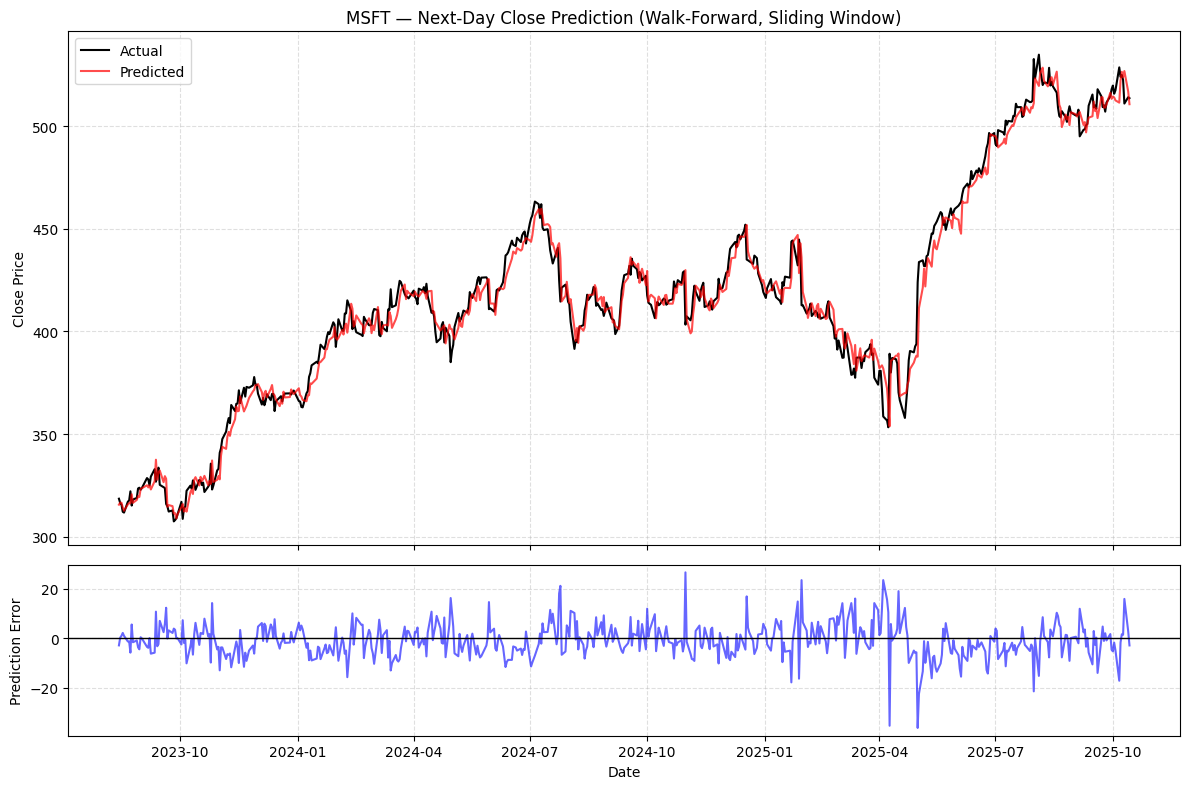

In [32]:
X, y, target_dates, feature_dates = create_features(data, lag)

results, metrics = walk_forward_sliding_window(
    X, y, target_dates,
    train_window=train_window,
    step=1, # predict daily
    params=study.best_params,
)

print("\nWalk-forward metrics with best params:")
print(metrics)

plot_walk_forward_results(results, ticker)


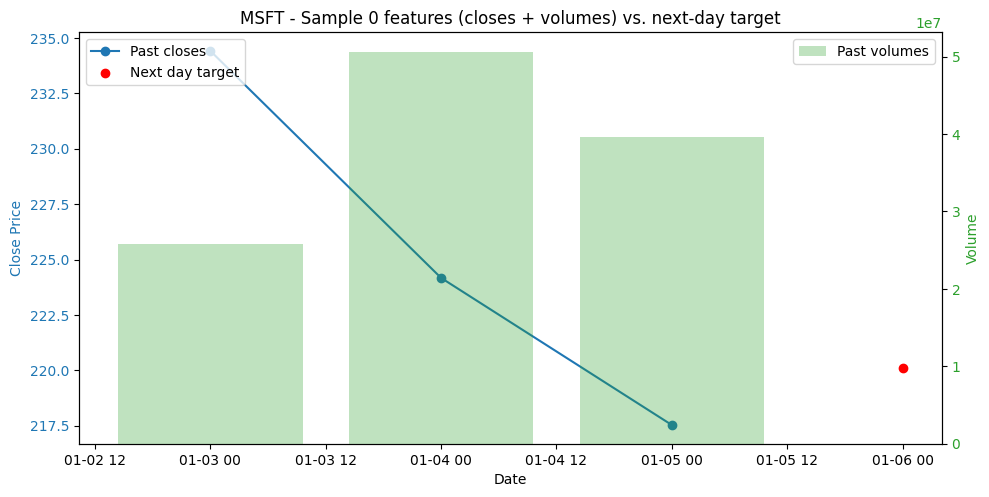

In [33]:
plot_sample(X, y, target_dates, feature_dates, sample_idx=0, lag=lag, ticker=ticker)